In [31]:
import numpy as np
from scipy.integrate import dblquad
import matplotlib.pyplot as plt

# 定义被积函数 f(theta, phi)
def integrand(phi, theta, gamma):
    numerator = 1 - gamma * np.sin(theta)**2 * np.cos(phi) * np.sin(phi)
    denominator = 1 + gamma**2 * np.sin(theta)**2 * np.sin(phi)**2 - gamma * np.sin(theta)**2 * np.sin(2 * phi)
    return 5 * numerator / denominator * (-gamma) * np.sin(theta)

# 计算 Q(t', t) 的数值积分
def calculate_Q(gamma):
    result, _ = dblquad(integrand, 0, np.pi, lambda theta: 0, lambda theta: 2 * np.pi, args=(gamma,))
    return result / (4 * np.pi)

# 定义记忆函数 M(t-t')
def memory_function(t, t_prime, G, lambda_i):
    return G / lambda_i * np.exp((t_prime - t) / lambda_i)

# 计算应力的函数
def calculate_stress(t_values, gamma_values, Q_values, G, lambda_i):
    dt = t_values[1] - t_values[0]  # 时间步长
    stress = np.zeros_like(t_values)
    
    # 记忆函数在 t=t' 时的值
    M_0 = memory_function(0, 0, G, lambda_i)
    
    # 后向欧拉法迭代
    for i in range(1, len(t_values)):
        stress[i] = stress[i - 1] + M_0 * Q_values[i-1] * dt
    
    return stress
gamma0=0.1
# 定义应变协议
def sin1(t_values, omega):
    return np.cos(omega * t_values)*gamma0

def sin2(t_values, omega):
    return np.cos(omega * t_values/2)*gamma0

def sin3(t_values, omega):
    return np.cos(omega * t_values/3)*gamma0

def sin4(t_values, omega):
    return 1.5*np.cos(omega * t_values)*gamma0

def linear(t_values):
    return t_values / t_values[-1]*gamma0  # 线性增加到 1
# 设置参数
G = 1
lambda_i = 0.1
t_start = 0.0
dt = 0.01
omega = np.pi  # 角频率
T = 2 * np.pi / omega  # 周期
t_end = 5 * T

# 生成时间数组
t_values = np.arange(t_start, t_end, dt)

# 定义应变协议列表
strain_protocols = {
    "sin1": sin1(t_values, omega),
    "sin2": sin2(t_values, omega),
    "sin3": sin3(t_values, omega),
    "sin4": sin4(t_values, omega),
    "Linear": linear(t_values)
}

# 计算每个应变协议的应力和 Q 值
stress_results = {}
for name, gamma_values in strain_protocols.items():
    Q_values = np.array([calculate_Q(gamma) for gamma in gamma_values])
    stress = calculate_stress(t_values, gamma_values, Q_values, G, lambda_i)
    stress_results[name] = (gamma_values, stress)



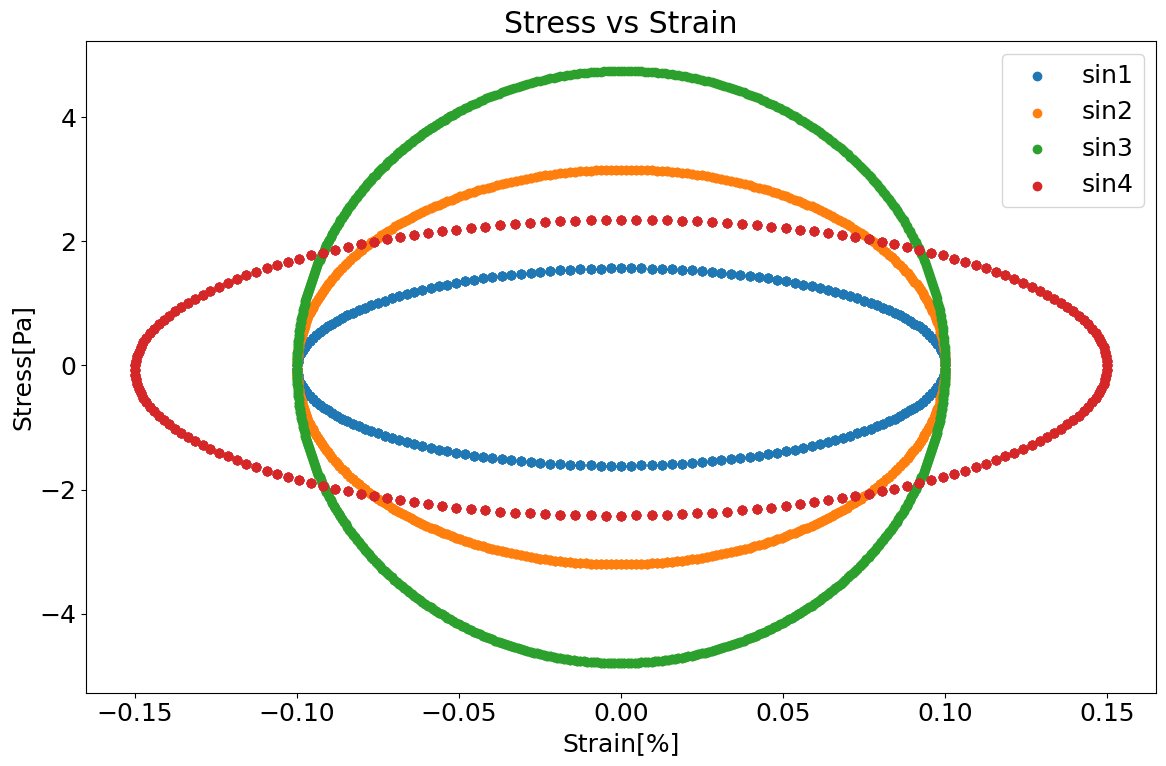

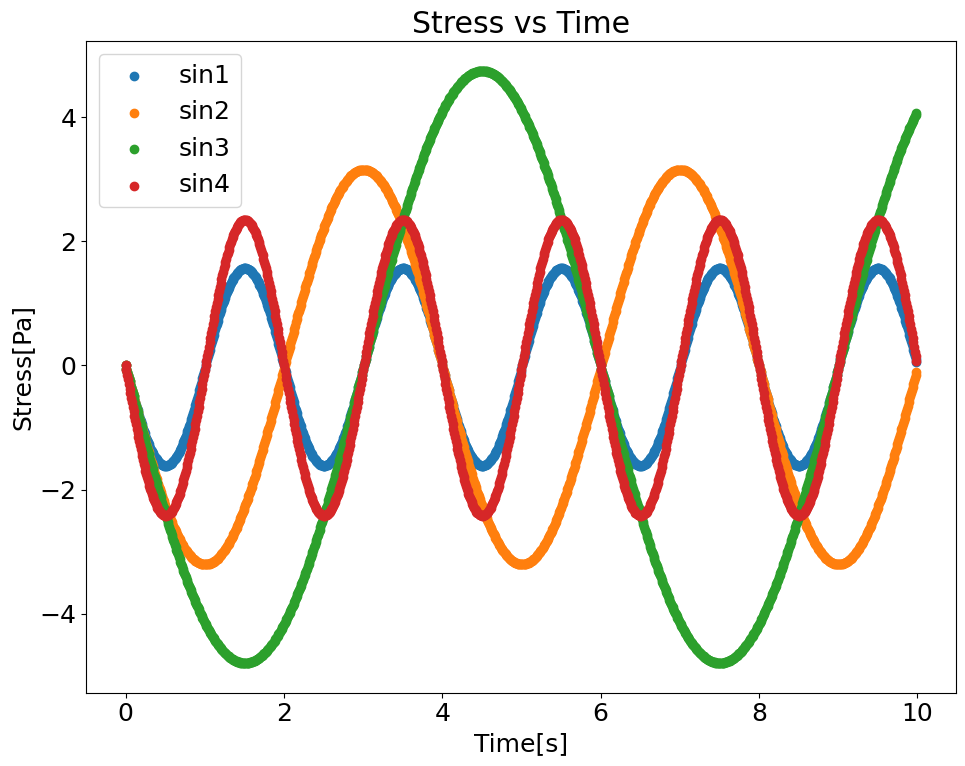

In [32]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 设置全局字体大小为 18

# 第一张图：应力-应变曲线
plt.figure(figsize=(12, 8))  # 设置画布大小
for name, (gamma_values, stress) in stress_results.items():
    if name == 'Linear':
        continue  # 跳过线性应变协议
    plt.scatter(gamma_values, stress, label=name)
plt.xlabel('Strain[%]')
plt.ylabel('Stress[Pa]')
plt.title('Stress vs Strain')
plt.legend()
plt.tight_layout()
plt.show()  # 显示第一张图

# 第二张图：应力-时间曲线
plt.figure(figsize=(10, 8))  # 设置画布大小
for name, (gamma_values, stress) in stress_results.items():
    if name == 'Linear':
        continue  # 跳过线性应变协议
    plt.scatter(t_values, stress, label=name)
plt.xlabel('Time[s]')
plt.ylabel('Stress[Pa]')
plt.title('Stress vs Time')
plt.legend()
plt.tight_layout()
plt.show()  # 显示第二张图

In [33]:
import pandas as pd
from openpyxl import Workbook
# 将结果保存到 Excel 文件
output_file = 'data/doi_edwards_test.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for name, (gamma_values, stress) in stress_results.items():
        # 创建 DataFrame
        data = pd.DataFrame({
            'Time[s]': t_values,
            'Stress[Pa]': stress,
            'Strain[%]': gamma_values,
            'Strain Rate[1/s]': np.gradient(gamma_values,dt)
        })
        # 保存到不同的工作簿
        data.to_excel(writer, sheet_name=name, index=False)

print(f"结果已保存到 {output_file}")

结果已保存到 data/doi_edwards_test.xlsx
